In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q evaluate jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 70.1 MB/s eta 0:00:00


In [ ]:
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainingArguments, Seq2SeqTrainer, PreTrainedTokenizerFast, AutoTokenizer
from datasets import Dataset, Features, Value
from torchvision import transforms
from evaluate import load
import torch
import os
import pandas as pd
import numpy as np

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Paths to data and tokenizer
base_path = "/content/drive/MyDrive/Datasets/Datasets/Malayalam_HRT"
train_csv = os.path.join(base_path, "train_df.csv")
val_csv = os.path.join(base_path, "val_df.csv")
test_csv = os.path.join(base_path, "test_df.csv")
tokenizer_path = "/content/drive/MyDrive/Datasets/Datasets/Malayalam_Large_Corpus/MaLCust_HF_PtTokenizer24M"  # Custom trained malayalam Tokenizer

In [ ]:
# Load CSV files
train_df = pd.read_csv(train_csv).sample(n=800, random_state=42)
val_df = pd.read_csv(val_csv).sample(n=100, random_state=42)
test_df = pd.read_csv(test_csv).sample(n=100, random_state=42)


In [ ]:
# Verify dataset sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 800
Validation size: 100
Test size: 100


In [ ]:
print(f"Train sample: {train_df.head(10)}")
print("="*50)
print(f"validation sample: {val_df.head(10)}")
print("="*50)
print(f"Test sample: {test_df.head(10)}")

Train sample:                 Images              text
46670  train/46817.jpg            കണ്ണമം
44737  train/44879.jpg  സംഭവിക്കുന്നപോലെ
46520  train/46667.jpg          ഭേദിച്ച്
34967  train/35068.jpg          ഉണ്ടെന്ന
84262  train/84508.jpg     പടവുകളിറങ്ങിയ
77330  train/77569.jpg      ഉവ്വാപ്പള്ളി
67599  train/67811.jpg   മെച്ചപ്പെടുത്തി
18248  train/18302.jpg         കലരുന്നത്
32047  train/32136.jpg   പുകയിലലോബിയെയും
36560  train/36673.jpg       ലഭിക്കാനാണ്
validation sample:               Images               text
11685  val/11726.jpg             അവനാണ്
5652    val/5677.jpg         പൂയംകുട്ടി
4794    val/4816.jpg  വേണ്ടപ്പെട്ടവരായി
2473    val/2485.jpg   എടുക്കുന്നതിനാണ്
2184    val/2196.jpg   വ്യത്യസ്ഥതകൊണ്ട്
10212  val/10250.jpg       മാമുക്കോയയും
2929    val/2944.jpg                നും
9780    val/9818.jpg            ക്കുള്ള
9554    val/9591.jpg           പറയേണ്ടി
5019    val/5042.jpg        സ്വീകരിച്ചു
Test sample:                Images               text
9477    test/9496.jpg 

In [ ]:
# Load custom tokenizer (SentencePiece BPE)
tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_path,
    bos_token="<s>",
    eos_token="</s>",
    sep_token="<sep>",
    pad_token="<pad>",
    unk_token="<unk>",
)

In [ ]:
# Testing tokenization
sample_text = "നിന്റെ പേര് എന്താണ്"
token_ids = tokenizer.encode(sample_text)
tokens = tokenizer.convert_ids_to_tokens(token_ids)
print(f"Sample Malayalam text tokenized: {tokens}")

Sample Malayalam text tokenized: ['<s>', '▁നിന്റെ', '▁പേര്', '▁എന്താണ്', '</s>']


In [ ]:
# For Image processing
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten", tokenizer=tokenizer)

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
# Load model and resize embeddings
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")
model.decoder.resize_token_embeddings(len(tokenizer))

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

TrOCRScaledWordEmbedding(32002, 1024, padding_idx=1)

In [ ]:
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

In [ ]:
# Check alignment between tokenizer vocab and embedding layer
tokenizer_vocab_size = len(tokenizer)
embedding_size = model.decoder.model.decoder.embed_tokens.weight.size(0)
print(f"Tokenizer vocab size: {tokenizer_vocab_size}")
print(f"Decoder embedding layer size: {embedding_size}")
if tokenizer_vocab_size == embedding_size:
    print("Alignment confirmed: Tokenizer vocab matches decoder embedding layer.")
else:
    raise ValueError("Mismatch detected! Tokenizer vocab and embedding layer sizes differ.")

Tokenizer vocab size: 32002
Decoder embedding layer size: 32002
Alignment confirmed: Tokenizer vocab matches decoder embedding layer.


In [ ]:
def get_preprocess_fn(processor, tokenizer):
    def preprocess_data(examples):
        images = []
        labels_text = []

        for image_path, label in zip(examples["image_path"], examples["label"]):
            try:
                img = Image.open(image_path).convert("RGB")
                if isinstance(label, str) and label.strip():
                    images.append(img)
                    labels_text.append(label)
                else:
                    print(f"[⚠️ Warning] Invalid label for {image_path}: {label}")
            except Exception as e:
                print(f"[❌ Error] Loading image {image_path}: {e}")
                continue

        # Use processor.image_processor
        image_encoding = processor.image_processor(images=images, return_tensors="pt")

        # Tokenize labels
        label_encoding = tokenizer(
            labels_text,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            max_length=128
        )

        # Overflow check
        for i, input_ids in enumerate(label_encoding["input_ids"]):
            if (input_ids > 2**63 - 1).any():
                print(f"[🚨 Overflow] Label at index {i} has long token ID: {input_ids}")

        return {
            "pixel_values": image_encoding["pixel_values"],
            "labels": label_encoding["input_ids"]
        }

    return preprocess_data


def create_datasets(df, base_path, processor, tokenizer, split="train"):
    image_paths = []
    for path in df["Images"]:
        if not os.path.isabs(path):
            path = os.path.join(base_path, path)
        image_paths.append(path)

    dataset = Dataset.from_dict({
        "image_path": image_paths,
        "label": df["text"].tolist()
    }, features=Features({
        "image_path": Value("string"),
        "label": Value("string")
    }))

    preprocess_fn = get_preprocess_fn(processor, tokenizer, apply_augmentation=False)
    dataset = dataset.map(preprocess_fn, batched=True, remove_columns=["image_path", "label"])
    dataset.set_format("torch")
    return dataset


In [ ]:
train_dataset = create_datasets(train_df, base_path, processor, tokenizer, split="train")
val_dataset = create_datasets(val_df, base_path, processor, tokenizer, split="val")
test_dataset = create_datasets(test_df, base_path, processor, tokenizer, split="test")

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 800
Validation dataset size: 100
Test dataset size: 100


In [ ]:
# train_dataset.save_to_disk("/content/drive/MyDrive/Datasets/Datasets/Malayalam_HRT/Sample_HF_data2/train") #optional for future use
# val_dataset.save_to_disk("/content/drive/MyDrive/Datasets/Datasets/Malayalam_HRT/Sample_HF_data2/val")
# test_dataset.save_to_disk("/content/drive/MyDrive/Datasets/Datasets/Malayalam_HRT/Sample_HF_data2/test")

Saving the dataset (0/3 shards):   0%|          | 0/800 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
# Load It Later
# from datasets import load_from_disk

# train_dataset = load_from_disk("./processed/train")
# val_dataset = load_from_disk("./processed/val")
# test_dataset = load_from_disk("./processed/test")

In [ ]:
# Load metrics
cer_metric = load("cer")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    if isinstance(predictions, tuple):
        predictions = predictions[0]

    if predictions.ndim == 3:
        predictions = np.argmax(predictions, axis=-1)

    predictions = np.clip(predictions, 0, tokenizer.vocab_size - 1)
    predictions = predictions.astype(np.int32)
    labels = np.where(labels == -100, tokenizer.pad_token_id, labels)
    labels = labels.astype(np.int32)

    pred_texts = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    label_texts = tokenizer.batch_decode(labels, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_texts, references=label_texts)
    return {"cer": cer}


In [ ]:
training_args2 = Seq2SeqTrainingArguments(
    output_dir="/content/Checkpoints/trocr-malayalam",  # Save path
    num_train_epochs=10,                                # You can reduce if overfitting
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,                      # Effective batch size 4x2= 8
    eval_strategy="steps",
    eval_steps=250,
    save_strategy="steps",
    save_steps=250,
    logging_steps=50,
    learning_rate=2e-5,
    warmup_steps=50,
    weight_decay=0.01,
    predict_with_generate=True,
    load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
    save_total_limit=1,
    remove_unused_columns=False,
    fp16=True,
    report_to="none",
)

In [ ]:
# Initialize Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args2,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
# Fine-tune the model
trainer.train()


Step,Training Loss,Validation Loss,Cer
250,0.026900,0.250128,0.915296
500,0.003500,0.262853,0.877467
750,0.000800,0.264811,0.900493
1000,0.000500,0.269520,0.888158


There were missing keys in the checkpoint model loaded: ['decoder.output_projection.weight'].


TrainOutput(global_step=1000, training_loss=0.019129790043458342, metrics={'train_runtime': 1134.1042, 'train_samples_per_second': 7.054, 'train_steps_per_second': 0.882, 'total_flos': 5.986281527967744e+18, 'train_loss': 0.019129790043458342, 'epoch': 10.0})

In [ ]:
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

Test Results: {'eval_loss': 0.25312045216560364, 'eval_cer': 0.8868648130393096, 'eval_runtime': 17.8162, 'eval_samples_per_second': 5.613, 'eval_steps_per_second': 1.403, 'epoch': 10.0}


In [ ]:
# Save model, processor, tokenizer
model.save_pretrained("./trocr-finetuned-malayalam/final")
processor.save_pretrained("./trocr-finetuned-malayalam/final")
tokenizer.save_pretrained("./trocr-finetuned-malayalam/final")


('./trocr-finetuned-malayalam/final/tokenizer_config.json',
 './trocr-finetuned-malayalam/final/special_tokens_map.json',
 './trocr-finetuned-malayalam/final/sentencepiece.bpe.model',
 './trocr-finetuned-malayalam/final/added_tokens.json',
 './trocr-finetuned-malayalam/final/tokenizer.json')


Sample 1:
Image: test/9496.jpg
Ground Truth: കിട
Predicted: പോ


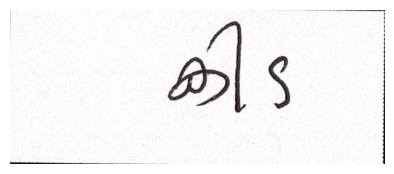


Sample 2:
Image: test/5927.jpg
Ground Truth: അഴിമതിക്കുമെതിരെ
Predicted: അവതരിപ്പിക്കയായിരുന്നു


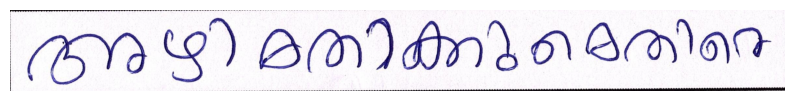


Sample 3:
Image: test/15543.jpg
Ground Truth: അനുവദിക്കില്ലെന്ന
Predicted: ിയെടുക്കാണ്


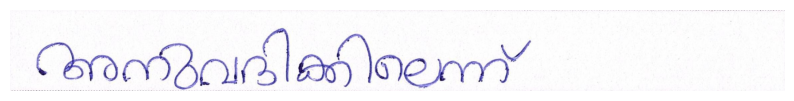


Sample 4:
Image: test/7126.jpg
Ground Truth: മൈനസ്
Predicted: അത


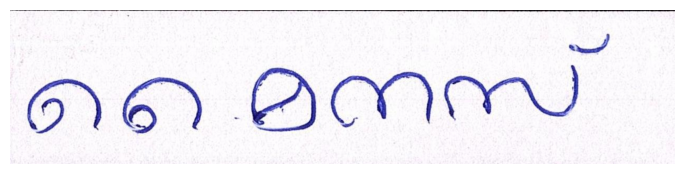


Sample 5:
Image: test/3755.jpg
Ground Truth: കാത്തിരിക്കേണ്ടി
Predicted: കഴിഞ്ഞ്


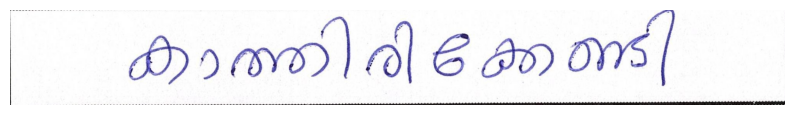

In [ ]:
import matplotlib.pyplot as plt
# test samples
num_samples = 5
for i in range(min(num_samples, len(test_df))):
    sample_image_path = test_df["Images"].iloc[i]
    full_path = os.path.join(base_path, sample_image_path)
    sample_image = Image.open(full_path).convert("RGB")
    pixel_values = processor(images=sample_image, return_tensors="pt").pixel_values

    device = "cuda" if torch.cuda.is_available() else "cpu"
    pixel_values = pixel_values.to(device)
    model.to(device)

    generated_ids = model.generate(pixel_values)
    predicted_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    ground_truth = test_df["text"].iloc[i]

    print(f"\nSample {i+1}:")
    print(f"Image: {sample_image_path}")
    print(f"Ground Truth: {ground_truth}")
    print(f"Predicted: {predicted_text}")

    plt.figure(figsize=(10, 2))
    plt.imshow(sample_image, cmap="gray")
    # plt.title(f"Sample {i+1}\nGround Truth: {ground_truth}\nPredicted: {predicted_text}")
    plt.axis("off")
    plt.show()

Testing by Loading model from local storage

In [ ]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
from PIL import Image


model_directory = "/content/drive/MyDrive/Datasets/Datasets/Malayalam_HRT/trocr-finetuned-malayalam/final"
processor_cust = TrOCRProcessor.from_pretrained(model_directory)
model_cust = VisionEncoderDecoderModel.from_pretrained(model_directory)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cust.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (i

Predicted text: സാമ്പത്തിക എന്ന


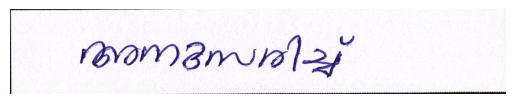

In [ ]:

image_path = "/content/drive/MyDrive/Datasets/Datasets/Sample_Mal_HRT/test/8.jpg"
image = Image.open(image_path).convert("RGB")


pixel_values = processor_cust(images=image, return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)
generated_ids = model_cust.generate(pixel_values)
generated_text = processor_cust.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(f"Predicted text: {generated_text}")
plt.imshow(image)
plt.axis('off')
plt.show()

#**Plot training curves**

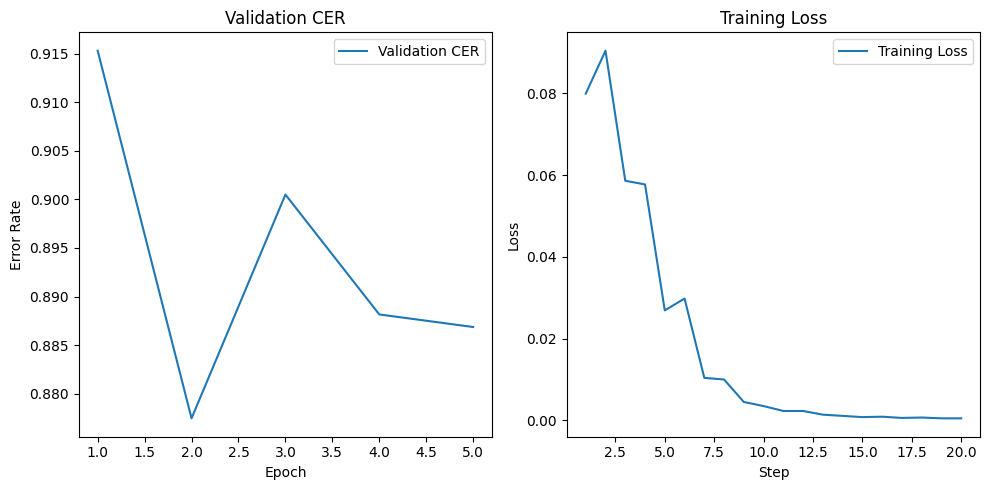

In [ ]:
# Plot training curves
log_history = trainer.state.log_history
train_loss = [log["loss"] for log in log_history if "loss" in log]
eval_cer = [log["eval_cer"] for log in log_history if "eval_cer" in log]
epochs = range(1, len(eval_cer) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, eval_cer, label="Validation CER")
plt.xlabel("Epoch")
plt.ylabel("Error Rate")
plt.title("Validation CER")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Datasets/Datasets/Malayalam_HRT/trocr-finetuned-malayalam/training_curves.png")
plt.show()

In [ ]:
# Save metrics to CSV
metrics_df = pd.DataFrame({
    "Epoch": epochs,
    "Validation CER": eval_cer})
metrics_df.to_csv("/content/metrics.csv", index=False)
print("Metrics saved")

Metrics saved
